# Testing Models that Include Dielectric Constant as an Input
A few of our modelling strategies employ the dielectric constant as an input to the model. 
Here, we test whether these models reasonably predict the sovlation energy for dielectric constants not included in the dataset.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from jcesr_ml.benchmark import load_benchmark_data, dielectric_constants
from jcesr_ml.mpnn import set_custom_objects, run_model
from sklearn.metrics import mean_absolute_error, r2_score
from nfp.preprocessing import GraphSequence
from keras.models import load_model
import pickle as pkl
import pandas as pd
import numpy as np
import os

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Using TensorFlow backend.
/home/wardlt/miniconda3/envs/solv_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wardlt/miniconda3/envs/solv_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wardlt/miniconda3/envs/solv_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wardlt/m

Set up the environment

In [2]:
set_custom_objects()

In [3]:
data = pd.concat(load_benchmark_data())

## Build Utility Scripts
Scripts used to assess model performance

In [4]:
models = pd.read_json('mpnn-results.json')

In [5]:
def load_solv_model(desc):
    """Loads a model and associated featurizer
    
    Args:
        desc (dict): Model configuration
    Returns:
        - (Model) Keras model
        - (SmilesPreprocesser) Associated featurizer
    """
    
    # Check if network name is in the description
    if 'network' not in desc:
        raise ValueError('`network` must be included in the model configuration')
        
    # Load in the converter
    conv_path = os.path.join('networks', desc['network'], 'converter.pkl')
    with open(conv_path, 'rb') as fp:
        conv = pkl.load(fp)
    
    # Find the desired model
    query = ' and '.join(f'{k}=="{v}"' for k, v in desc.items())
    hits = models.query(query)
    if len(hits) > 1:
        raise ValueError(f'Found more than one match: {hits["path"].tolist()}')
    elif len(hits) == 0:
        raise ValueError(f'No such model for query: {query}')
    model_info = hits.iloc[0]
    model = load_model(os.path.join(model_info['path'], 'best_model.h5'))
    
    # Warn if model hasn't finished training
    if not model_info['finished']:
        print('WARNING: Model has not finished training')
    
    return model, conv

## Plot the Performance of One Model on a Few Molecules
Just to see what we're working with. Are the predictions smooth and accurate?

In [6]:
model, conv = load_solv_model({'network': 'dielectric-constant-softplus_no-acn', 'batch_size': 16384})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/home/wardlt/miniconda3/envs/solv_ml/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [7]:
def eval_solvation_energy(model, conv, mol, e):
    """Predict the solvation energy as a function of dielectric constant
    
    Args:
        model (Model): Solvation energy model
        conv (SmilesPreprocessor): Tool to generate inputs for model
        mol (str): SMILES string of the molecule
        c (ndarray): Dielectric constants at which to evaluate the dielectric constants
    Returns:
        
    """
    
    # Set the dielectric constants
    conv.dielectric_cnsts = e
    
    # Turn the molecule into a graph sequence
    g = GraphSequence(list(conv.preprocess([mol])))
    
    # Pipe the sequence through the model
    return np.squeeze(model.predict_on_batch(g[0]))

In [8]:
def get_ground_truth(mol):
    """Get the actual solvation energies for a certain molecule
    
    Args:
        mol (str): SMILES string of the molecule
    Returns:
        - (ndarray) Dielectric constants
        - (ndarray) Solvation energies
        - (bool) Whether molecule was in the test set
    """
    
    # Find the molecule
    hits = data.query(f'smiles_0 == "{mol}"')
    if len(hits) != 1:
        raise ValueError(f'This query did not work: {mol}')
        
    # Return its values
    sol_cols = [x for x in data.columns if x.startswith('sol_')]
    sols = hits.iloc[0][sol_cols]
    dec = np.array([dielectric_constants[s] for s in sol_cols])
    return dec, sols, hits.iloc[0]['in_holdout'], sol_cols

Plot a few reprentative molecules

In [9]:
mols_to_plot = [
    ('CCC', 'Propane'),
    ('O', 'Water'), 
    ('CCCCCCCO', '1-Heptanol'),
    ('C1=CC=CC=C1', 'Benzene')
]

100%|██████████| 1/1 [00:00<00:00, 843.08it/s]


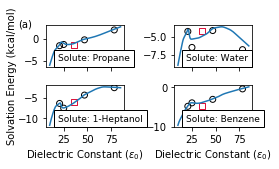

In [10]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(3.75, 2.25))


e = np.linspace(10, 85, 128)
for (smiles, name), ax in zip(mols_to_plot, axs.flatten()):
    e_true, s_true, holdout, sol_cols = get_ground_truth(smiles)
    s = eval_solvation_energy(model, conv, smiles, e)
    
    # Get the ACN column that was held out
    mask = np.array(sol_cols) == "sol_acn"
    ax.scatter(e_true[~ mask], s_true[~ mask], marker='o', facecolor='none', edgecolor='k')
    ax.scatter(e_true[mask], s_true[mask], marker='s', facecolor='none', edgecolor='crimson')
    ax.plot(e, s)
    ax.text(0.15, 0.1, f'Solute: {name}', transform=ax.transAxes, va='bottom', ha='left',
           fontsize=9, bbox={'facecolor': 'w'})
    
fig.text(0.01, 0.6, 'Solvation Energy (kcal/mol)', rotation='vertical', ha='left', va='center')
for ax in axs[-1, :]:
    ax.set_xlabel('Dielectric Constant ($\epsilon_0$)')
fig.text(0.05, 0.9, '(a)')
    
fig.tight_layout(rect=[0.01, 0, 1, 1])
fig.savefig(os.path.join('figures', 'dielectric-constant-effect.png'), dpi=320)
fig.savefig(os.path.join('figures', 'dielectric-constant-effect.eps'))

*Finding*: Our model does reasonably on a predicting a few varied molecules. We also see some unphsyiscal changes in the prediciton accuracy outside of the region of the training set.

## Plot for the Entire Dataset
See how our model does for the solvation energy of all of the models

In [11]:
test_data = data  # Plot the full dataset
print(f'Evaluating on {len(test_data)} points')

Evaluating on 130258 points


In [12]:
acn_e = dielectric_constants['sol_acn']

In [13]:
conv.dielectric_cnsts = [acn_e]

In [14]:
%%time
test_data['sol_acn_pred'] = run_model(model, conv, test_data['smiles_0'], n_jobs=4, chunk_size=2048)

CPU times: user 16min 28s, sys: 16min 49s, total: 33min 17s
Wall time: 11min 58s


Measure MAE on the holdout set

In [15]:
subset = test_data.query('in_holdout')
holdout_mae = mean_absolute_error(subset['sol_acn_pred'], subset['sol_acn'])
print(f'MAE on holdout set: {holdout_mae:.3f} kcal/mol')

MAE on holdout set: 0.630 kcal/mol


Measure the performance compared to using solvation energy in DMSO as a proxy

In [16]:
dielectric_constants

{'sol_acetone': 20.493,
 'sol_acn': 35.688,
 'sol_dmso': 46.826,
 'sol_ethanol': 24.852,
 'sol_water': 78.3553}

Interpolate between DMSO and enthanol

In [17]:
frac_eth = abs(dielectric_constants['sol_acn'] - dielectric_constants['sol_dmso']) / (dielectric_constants['sol_dmso'] - dielectric_constants['sol_ethanol'])

In [18]:
for m in [r2_score, mean_absolute_error]:
    m_score = m(test_data['sol_acn'], test_data['sol_acn_pred'])
    d_score = m(test_data['sol_acn'], test_data['sol_dmso'])
    e_score = m(test_data['sol_acn'], test_data['sol_ethanol'])
    i_score = m(test_data['sol_acn'], frac_eth * test_data['sol_ethanol'] 
                + (1 - frac_eth) * test_data['sol_dmso'])
    print(f'{m.__name__} - Model {m_score: .3f} - DMSO {d_score: .3f} - Ethanol {e_score: .3f} - Interpolated {i_score: .3f}')

r2_score - Model  0.935 - DMSO  0.753 - Ethanol  0.800 - Interpolated  0.922
mean_absolute_error - Model  0.535 - DMSO  1.201 - Ethanol  0.947 - Interpolated  0.601


Plot the results

In [19]:
perc_95 = np.percentile((test_data['sol_acn'] - test_data['sol_acn_pred']).abs(), 99)
print(f'99th percentile for error: {perc_95: .2f} kcal/mol')

99th percentile for error:  1.80 kcal/mol


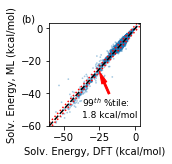

In [20]:
fig, ax = plt.subplots(figsize=(2.25, 2.25))

lims = np.array([-60, test_data['sol_acn'].max()])
ax.scatter(test_data['sol_acn'], test_data['sol_acn_pred'], s=3, alpha=0.4, edgecolor='none')

ax.set_xlim(min(lims), max(lims))
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
ax.plot(lims, lims+perc_95, 'r:', lw=1.5)
ax.plot(lims, lims-perc_95, 'r:', lw=1.5)

#ax.text(0.05, 0.9, f'MAE:{mean_absolute_error(test_data["sol_acn"], test_data["sol_acn_pred"]): .2f} kcal/mol',
#       fontsize=9, transform=ax.transAxes, ha='left')
ax.annotate(f'99$^{{th}}$ %tile:\n{perc_95:.1f} kcal/mol', xy=(-25, -25-perc_95), xytext=(-37, -55), 
            fontsize=9, arrowprops={'width': 1.8, 'headwidth': 5.4, 'color': 'r'})

ax.set_xlabel('Solv. Energy, DFT (kcal/mol)')
ax.set_ylabel('Solv. Energy, ML (kcal/mol)')
fig.text(0.15, 0.9, '(b)')

fig.tight_layout()
fig.savefig(os.path.join('figures', 'acn-dielectric-model.png'), dpi=320)

*Finding*: We do pretty well without having ACN in the training set. Statistics are better than just using the DMSO or Ethanol as proxies